# Day 67: Implementing Transfer Learning with Pre-trained Models

## Introduction

Transfer learning is one of the most powerful techniques in modern machine learning and deep learning. Instead of training a model from scratch, transfer learning allows us to leverage knowledge from models that have already been trained on large datasets. This approach can dramatically reduce training time, improve model performance, and enable effective learning even with limited data.

Imagine you're learning to play the piano. If you already know how to play the guitar, you'll find it easier to understand musical notation, rhythm, and finger coordination. Similarly, in machine learning, a model trained on millions of images can transfer its learned features (like edge detection, texture recognition, and pattern identification) to help classify a new, specific set of images.

Transfer learning has become essential in modern AI applications, particularly in computer vision and natural language processing, where training large models from scratch would require massive computational resources and datasets that most practitioners don't have access to.

### Learning Objectives

By the end of this lesson, you will be able to:

- Understand the fundamental concepts and benefits of transfer learning
- Distinguish between feature extraction and fine-tuning approaches
- Implement transfer learning using pre-trained models from popular frameworks
- Apply transfer learning to solve real-world classification problems
- Evaluate and compare models trained with and without transfer learning

## Theory: Understanding Transfer Learning

### What is Transfer Learning?

Transfer learning is a machine learning technique where a model developed for one task is reused as the starting point for a model on a second task. It's a popular approach in deep learning because it allows us to build accurate models in a time-saving way.

The key insight behind transfer learning is that features learned by neural networks on large datasets are often transferable to other related tasks. For example, a model trained on ImageNet (a dataset with 14 million images across 1000 categories) learns to detect edges, shapes, textures, and complex patterns. These learned features are useful for many other image recognition tasks.

### Why Transfer Learning Works

Deep neural networks learn hierarchical representations:

1. **Early layers** learn general, low-level features (edges, corners, colors)
2. **Middle layers** learn more complex patterns (textures, shapes, simple objects)
3. **Later layers** learn task-specific, high-level features (specific objects, scenes)

Since early and middle layers learn general features applicable across many tasks, we can reuse these layers and only retrain the final layers for our specific task.

### Mathematical Foundation

In traditional supervised learning, we learn a function $f$ that maps inputs $X$ to outputs $Y$:

$$f: X \rightarrow Y$$

We minimize a loss function $L$ over our training data:

$$\min_{\theta} \sum_{i=1}^{n} L(f(x_i; \theta), y_i)$$

where $\theta$ represents all the parameters (weights and biases) of our neural network.

In transfer learning, we have:
- **Source domain** $D_S$ with task $T_S$ (e.g., ImageNet classification)
- **Target domain** $D_T$ with task $T_T$ (e.g., our specific classification problem)

The goal is to leverage knowledge from $(D_S, T_S)$ to improve learning of $T_T$ in $D_T$.

We decompose our neural network into two parts:

$$f(x; \theta) = g(h(x; \theta_h); \theta_g)$$

where:
- $h(x; \theta_h)$ is the feature extractor (early and middle layers) with parameters $\theta_h$
- $g(\cdot; \theta_g)$ is the classifier (final layers) with parameters $\theta_g$

### Two Main Approaches

#### 1. Feature Extraction

In feature extraction, we:
- **Freeze** the pre-trained layers ($\theta_h$ is fixed)
- Only train the new classifier layers ($\theta_g$)

The optimization becomes:

$$\min_{\theta_g} \sum_{i=1}^{n} L(g(h(x_i; \theta_h^*); \theta_g), y_i)$$

where $\theta_h^*$ are the frozen pre-trained weights.

**Advantages:**
- Very fast training (fewer parameters to update)
- Requires less data
- Lower computational cost

**Best for:** Small datasets, limited computational resources, tasks similar to the source task

#### 2. Fine-Tuning

In fine-tuning, we:
- Initialize with pre-trained weights
- Unfreeze some or all layers
- Train the entire network (or parts of it) with a small learning rate

The optimization updates both $\theta_h$ and $\theta_g$:

$$\min_{\theta_h, \theta_g} \sum_{i=1}^{n} L(g(h(x_i; \theta_h); \theta_g), y_i)$$

We typically use a smaller learning rate $\eta_{fine}$ compared to training from scratch:

$$\eta_{fine} \ll \eta_{scratch}$$

This is because we want to make small adjustments to the pre-trained weights rather than drastically changing them.

**Advantages:**
- Better performance on target task
- Can adapt to tasks different from source
- More flexible

**Best for:** Moderate to large datasets, tasks somewhat different from source, when you have computational resources

### When to Use Transfer Learning

Transfer learning is most effective when:

1. **Limited data:** You have a small dataset for your target task
2. **Similar tasks:** Source and target tasks are related (e.g., both are image classification)
3. **Computational constraints:** You don't have resources to train large models from scratch
4. **Time constraints:** You need quick results

### Popular Pre-trained Models

Several pre-trained models are commonly used:

- **VGG16/VGG19:** Deep networks with simple architecture (16 or 19 layers)
- **ResNet50/ResNet101:** Uses residual connections to train very deep networks (50-152 layers)
- **InceptionV3:** Uses inception modules with multiple filter sizes
- **MobileNet:** Lightweight model designed for mobile devices
- **EfficientNet:** State-of-the-art models with balanced depth, width, and resolution

These models are typically trained on ImageNet, a large dataset containing 1.4 million images across 1000 categories.

## Python Implementation

Let's implement transfer learning using TensorFlow and Keras. We'll use a pre-trained model and adapt it to classify a new dataset.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# For this lesson, we'll use TensorFlow/Keras
# Note: You may need to install tensorflow: pip install tensorflow
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    print(f"TensorFlow version: {tf.__version__}")
    print(f"Keras version: {keras.__version__}")
except ImportError:
    print("TensorFlow not found. For this lesson to run, install it with: pip install tensorflow")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

2025-11-09 11:57:20.764298: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-09 11:57:20.764824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:57:20.855750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-11-09 11:57:24.718349: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 11:57:24.732606: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
Keras version: 3.12.0
Libraries imported successfully!


### Step 1: Understanding Pre-trained Models

Let's first load a pre-trained model and examine its architecture.

In [2]:
# Load a pre-trained VGG16 model (without the top classification layer)
# include_top=False means we exclude the final dense layers
# We'll add our own classifier on top

base_model = VGG16(
    weights='imagenet',  # Use weights pre-trained on ImageNet
    include_top=False,   # Don't include the ImageNet classifier
    input_shape=(64, 64, 3)  # Our input image shape
)

print("Pre-trained VGG16 Model Architecture:")
print(f"Total layers: {len(base_model.layers)}")
print(f"Total parameters: {base_model.count_params():,}")

# Display the model summary (first few and last few layers)
print("\nFirst 5 layers:")
for i, layer in enumerate(base_model.layers[:5]):
    print(f"  Layer {i}: {layer.name} - {layer.__class__.__name__}")

print("\n... (more layers in between) ...")

print("\nLast 5 layers:")
for i, layer in enumerate(base_model.layers[-5:], start=len(base_model.layers)-5):
    print(f"  Layer {i}: {layer.name} - {layer.__class__.__name__}")

2025-11-09 11:57:25.660523: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 3661824/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

 9142272/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

14614528/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

19759104/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

24428544/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

29589504/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

35446784/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

42762240/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

49758208/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

55975936/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Pre-trained VGG16 Model Architecture:
Total layers: 19
Total parameters: 14,714,688

First 5 layers:
  Layer 0: input_layer - InputLayer
  Layer 1: block1_conv1 - Conv2D
  Layer 2: block1_conv2 - Conv2D
  Layer 3: block1_pool - MaxPooling2D
  Layer 4: block2_conv1 - Conv2D

... (more layers in between) ...

Last 5 layers:
  Layer 14: block4_pool - MaxPooling2D
  Layer 15: block5_conv1 - Conv2D
  Layer 16: block5_conv2 - Conv2D
  Layer 17: block5_conv3 - Conv2D
  Layer 18: block5_pool - MaxPooling2D


### Step 2: Visualizing Layer Outputs

Let's visualize what different layers in the network learn by examining their activations.

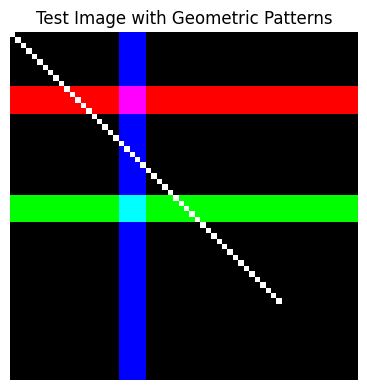

Test image shape: (64, 64, 3)
Test image batch shape: (1, 64, 64, 3)


In [3]:
# Create a simple synthetic image to visualize
# We'll create a simple pattern
test_image = np.zeros((64, 64, 3))

# Add some geometric patterns
# Horizontal lines
test_image[10:15, :, 0] = 255  # Red horizontal line
test_image[30:35, :, 1] = 255  # Green horizontal line
# Vertical lines
test_image[:, 20:25, 2] = 255  # Blue vertical line
# Diagonal pattern
for i in range(50):
    test_image[i, i, :] = 255  # White diagonal line

# Normalize the image
test_image = test_image / 255.0

# Add batch dimension
test_image_batch = np.expand_dims(test_image, axis=0)

plt.figure(figsize=(4, 4))
plt.imshow(test_image)
plt.title("Test Image with Geometric Patterns")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Test image shape: {test_image.shape}")
print(f"Test image batch shape: {test_image_batch.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


First layer activation shape: (1, 64, 64, 64)
This layer has 64 filters


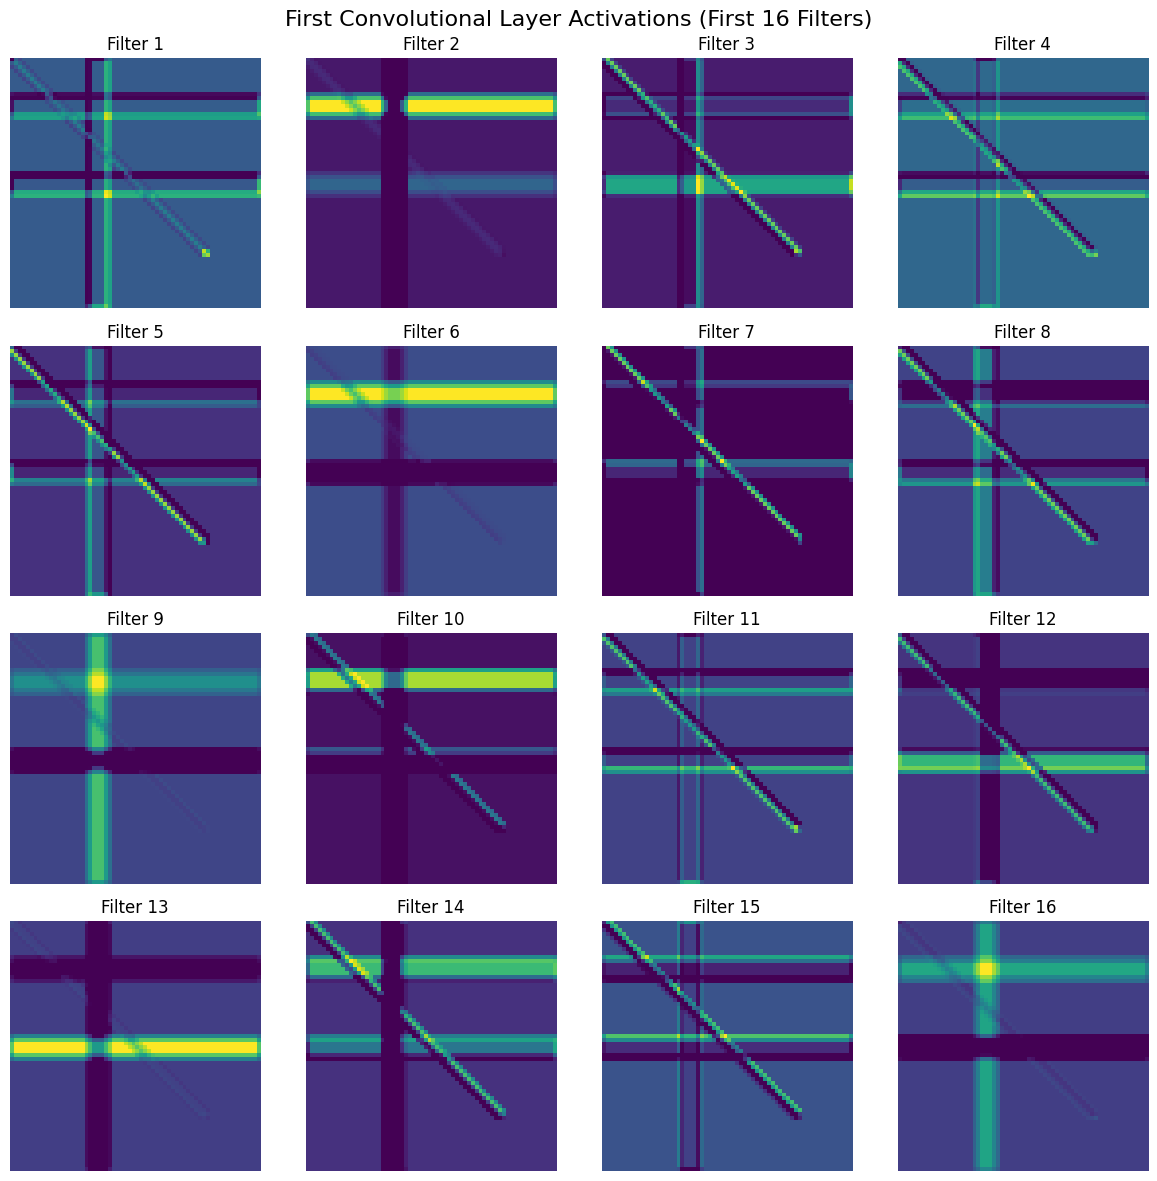


Observation: Early layers detect simple features like edges and corners.
Different filters activate for different patterns in the input image.


In [4]:
# Get outputs from different layers
layer_outputs = [layer.output for layer in base_model.layers[1:6]]  # First 5 conv layers
activation_model = models.Model(inputs=base_model.input, outputs=layer_outputs)

# Get activations
activations = activation_model.predict(test_image_batch)

# Visualize activations from the first convolutional layer
first_layer_activation = activations[0]
print(f"First layer activation shape: {first_layer_activation.shape}")
print(f"This layer has {first_layer_activation.shape[-1]} filters")

# Plot the first 16 filters
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < first_layer_activation.shape[-1]:
        ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
        ax.set_title(f'Filter {i+1}')
    ax.axis('off')

plt.suptitle('First Convolutional Layer Activations (First 16 Filters)', fontsize=16)
plt.tight_layout()
plt.show()

print("\nObservation: Early layers detect simple features like edges and corners.")
print("Different filters activate for different patterns in the input image.")

### Step 3: Creating a Synthetic Dataset

For this lesson, we'll create a synthetic dataset to demonstrate transfer learning. In practice, you would use your own dataset.

Dataset shape: (600, 64, 64, 3)
Labels shape: (600,)
Number of samples per class: 200
Total samples: 600


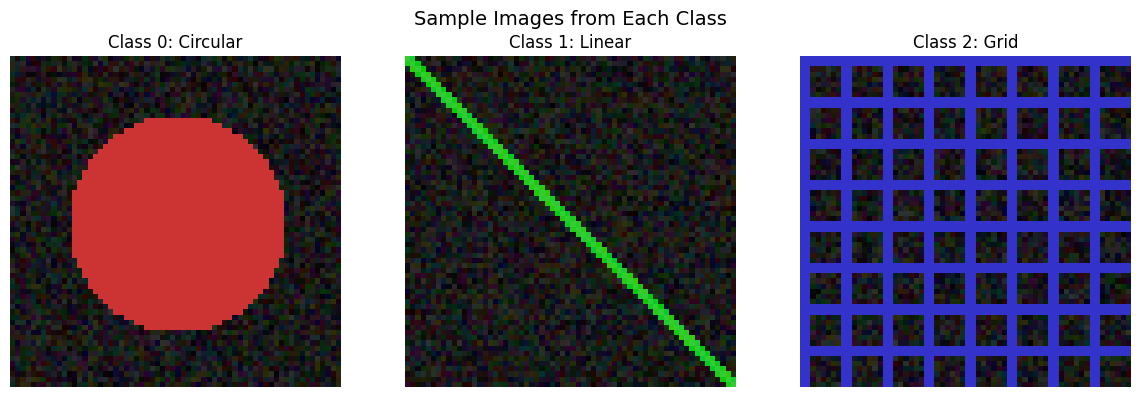

In [5]:
# Create a synthetic dataset with 3 classes
# Each class will have distinct visual characteristics

def create_synthetic_image(class_label, img_size=64):
    """
    Create synthetic images with different patterns for each class.
    
    Class 0: Circular patterns
    Class 1: Linear patterns
    Class 2: Grid patterns
    """
    img = np.random.rand(img_size, img_size, 3) * 0.2  # Base noise
    
    center = img_size // 2
    
    if class_label == 0:  # Circular patterns
        for i in range(img_size):
            for j in range(img_size):
                dist = np.sqrt((i - center)**2 + (j - center)**2)
                if dist < img_size // 3:
                    img[i, j, 0] = 0.8  # Red circle
                    img[i, j, 1] = 0.2
                    img[i, j, 2] = 0.2
    
    elif class_label == 1:  # Linear patterns
        # Add diagonal lines
        for i in range(img_size):
            if i < img_size:
                img[i, i, 1] = 0.8  # Green diagonal
                img[i, i, 0] = 0.2
                img[i, i, 2] = 0.2
                if i < img_size - 1:
                    img[i, i+1, 1] = 0.8
                if i > 0:
                    img[i, i-1, 1] = 0.8
    
    else:  # class_label == 2, Grid patterns
        # Create a grid
        for i in range(0, img_size, 8):
            img[i:i+2, :, 2] = 0.8  # Blue horizontal lines
            img[i:i+2, :, 0] = 0.2
            img[i:i+2, :, 1] = 0.2
            img[:, i:i+2, 2] = 0.8  # Blue vertical lines
            img[:, i:i+2, 0] = 0.2
            img[:, i:i+2, 1] = 0.2
    
    return img

# Generate dataset
num_samples_per_class = 200
num_classes = 3
img_size = 64

X = []
y = []

for class_label in range(num_classes):
    for _ in range(num_samples_per_class):
        img = create_synthetic_image(class_label, img_size)
        X.append(img)
        y.append(class_label)

X = np.array(X)
y = np.array(y)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of samples per class: {num_samples_per_class}")
print(f"Total samples: {len(X)}")

# Visualize sample images from each class
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
class_names = ['Circular', 'Linear', 'Grid']

for i in range(3):
    # Get a sample from each class
    sample_idx = np.where(y == i)[0][0]
    axes[i].imshow(X[sample_idx])
    axes[i].set_title(f'Class {i}: {class_names[i]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=14)
plt.tight_layout()
plt.show()

### Step 4: Preparing the Data

Let's split our data into training and testing sets.

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining set class distribution:")
for class_id, count in zip(unique, counts):
    print(f"  Class {class_id} ({class_names[class_id]}): {count} samples")

Training set size: 480
Test set size: 120

Training set shape: (480, 64, 64, 3)
Test set shape: (120, 64, 64, 3)

Training set class distribution:
  Class 0 (Circular): 160 samples
  Class 1 (Linear): 160 samples
  Class 2 (Grid): 160 samples


### Step 5: Building a Transfer Learning Model (Feature Extraction)

Let's build our first transfer learning model using the feature extraction approach.

In [7]:
# Load pre-trained VGG16 model without top layers
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)

# Freeze all layers in the base model
base_model_vgg.trainable = False

print("Base model (VGG16) trainable status:")
print(f"  Trainable: {base_model_vgg.trainable}")
print(f"  Total layers: {len(base_model_vgg.layers)}")
print(f"  Trainable weights: {len(base_model_vgg.trainable_weights)}")
print(f"  Non-trainable weights: {len(base_model_vgg.non_trainable_weights)}")

# Build the model with new classifier layers
model_feature_extraction = models.Sequential([
    base_model_vgg,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

print("\nComplete model summary:")
print(f"  Total parameters: {model_feature_extraction.count_params():,}")
print(f"  Trainable parameters: {sum([tf.size(w).numpy() for w in model_feature_extraction.trainable_weights]):,}")
print(f"  Non-trainable parameters: {sum([tf.size(w).numpy() for w in model_feature_extraction.non_trainable_weights]):,}")

Base model (VGG16) trainable status:
  Trainable: False
  Total layers: 19
  Trainable weights: 0
  Non-trainable weights: 26

Complete model summary:
  Total parameters: 14,879,299
  Trainable parameters: 164,611
  Non-trainable parameters: 14,714,688


### Step 6: Compiling and Training the Model

In [8]:
# Compile the model
model_feature_extraction.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")
print("\nTraining the feature extraction model...")

# Train the model
history_fe = model_feature_extraction.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("\nTraining completed!")

Model compiled successfully!

Training the feature extraction model...
Epoch 1/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3125 - loss: 1.7038

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3359 - loss: 1.5291

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3767 - loss: 1.4054

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4095 - loss: 1.3174

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4401 - loss: 1.2472

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4692 - loss: 1.1856

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4965 - loss: 1.1329

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5219 - loss: 1.0858

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5438 - loss: 1.0450

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5638 - loss: 1.0082

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5820 - loss: 0.9745

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5988 - loss: 0.9430

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7839 - loss: 0.5967 - val_accuracy: 1.0000 - val_loss: 0.0661


Epoch 2/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.1345

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.1297 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.1222

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.1145

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.1088

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.1045

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.1010

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0976

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0943

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0914

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0887

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0861

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0573 - val_accuracy: 1.0000 - val_loss: 0.0025


Epoch 3/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0369

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0323

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0284

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0256

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0236

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0220

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0207

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0196

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0187

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0179

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0172

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0166

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 3.4281e-04


Epoch 4/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 0.0091

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0071

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0061

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0059

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0057

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0055

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0053

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0051

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0049

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0048

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0047

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0046

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 1.2976e-04


Epoch 5/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 0.0016

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0018 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0017

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0018

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0019

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0019

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0019

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0019

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0020

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0020

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0020

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 7.5232e-05


Epoch 6/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0021

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0020

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0019

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0019

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0019

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0019

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0021

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0021

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0022

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0022

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0022

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 5.3184e-05


Epoch 7/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0017

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0015

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0013

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0012

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0011

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0010

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.8121e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 9.5864e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 9.3626e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 9.2412e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.1661e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 8.3401e-04 - val_accuracy: 1.0000 - val_loss: 4.2429e-05


Epoch 8/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 3.5924e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 3.5815e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 3.6103e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 4.0856e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 4.7055e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 5.0512e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 5.3077e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.4757e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 5.6803e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.0132e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.2721e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.4993e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 8.9986e-04 - val_accuracy: 1.0000 - val_loss: 3.4818e-05


Epoch 9/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0016

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0014

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0013

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0011

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0011

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0010

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 9.6168e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.3695e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.1319e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.8898e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.6595e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 8.5029e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 6.7799e-04 - val_accuracy: 1.0000 - val_loss: 2.8360e-05


Epoch 10/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 8.1658e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 8.1319e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 7.6641e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 7.2290e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 6.8906e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 6.6321e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.4356e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.5585e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.5975e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.6255e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.6538e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 6.6686e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 6.8307e-04 - val_accuracy: 1.0000 - val_loss: 2.3877e-05


Epoch 11/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 2.5848e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 4.1950e-04 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9072e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 5.4162e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.5829e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.5841e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.5399e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.4824e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.5278e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 5.5821e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 5.6176e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 5.7405e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 7.0925e-04 - val_accuracy: 1.0000 - val_loss: 2.0418e-05


Epoch 12/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.0037

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0029 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0024

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0021

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0018

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0017

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0015

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0014

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0014

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0013

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0013

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0012

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 8.6411e-04 - val_accuracy: 1.0000 - val_loss: 1.7552e-05


Epoch 13/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 1.9021e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 4.1037e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 4.3091e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 4.2049e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 4.1802e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 4.2181e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 4.4212e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 4.5475e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 4.7012e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 4.8178e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 4.8973e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 4.9644e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 1.0000 - loss: 5.7025e-04 - val_accuracy: 1.0000 - val_loss: 1.4727e-05


Epoch 14/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0014

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0013 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0012

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0011

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 9.9942e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 9.2953e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 8.7058e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 8.3832e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 8.1027e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 7.8430e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 7.6260e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 7.4428e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 5.4279e-04 - val_accuracy: 1.0000 - val_loss: 1.2794e-05


Epoch 15/15


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 2.3305e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 4.7874e-04 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 5.1944e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 6.7783e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 7.6728e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.1185e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 8.3462e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.4664e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.5227e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 8.5115e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.4618e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.4204e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 7.9647e-04 - val_accuracy: 1.0000 - val_loss: 1.0636e-05



Training completed!


### Step 7: Evaluating the Feature Extraction Model

In [9]:
# Evaluate on test set
test_loss, test_accuracy = model_feature_extraction.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Results (Feature Extraction):")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Make predictions
y_pred_fe = model_feature_extraction.predict(X_test)
y_pred_classes_fe = np.argmax(y_pred_fe, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes_fe, target_names=class_names))


Test Results (Feature Extraction):
  Test Loss: 0.0000
  Test Accuracy: 1.0000 (100.00%)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step 

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step



Classification Report:
              precision    recall  f1-score   support

    Circular       1.00      1.00      1.00        40
      Linear       1.00      1.00      1.00        40
        Grid       1.00      1.00      1.00        40

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



### Step 8: Visualizing Training History

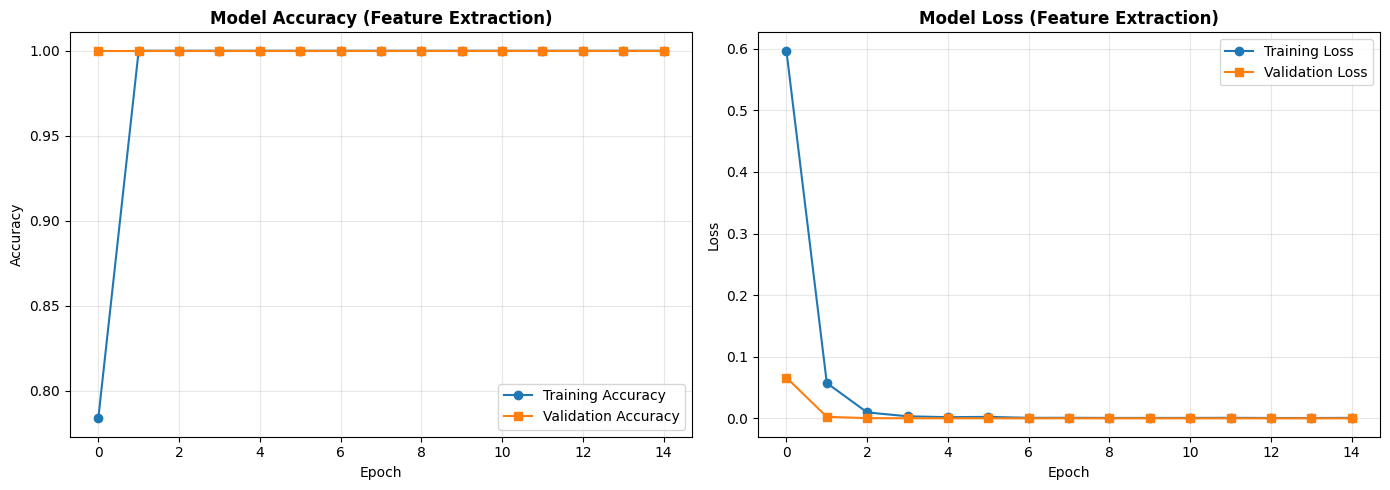


Observations:
- The model converges quickly due to pre-trained features
- Training is fast because we only update the classifier layers
- Validation accuracy closely tracks training accuracy


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history_fe.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history_fe.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy (Feature Extraction)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history_fe.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history_fe.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss (Feature Extraction)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- The model converges quickly due to pre-trained features")
print("- Training is fast because we only update the classifier layers")
print("- Validation accuracy closely tracks training accuracy")

### Step 9: Confusion Matrix Visualization

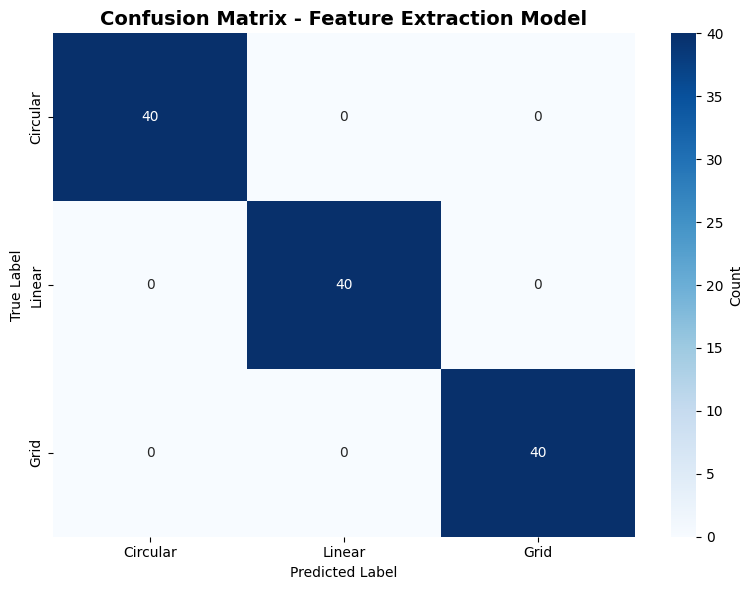


Per-class accuracy:
  Circular: 1.0000 (100.00%)
  Linear: 1.0000 (100.00%)
  Grid: 1.0000 (100.00%)


In [11]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes_fe)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Feature Extraction Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\nPer-class accuracy:")
for i, class_name in enumerate(class_names):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

### Step 10: Fine-Tuning Approach

Now let's try the fine-tuning approach where we unfreeze some layers and continue training.

In [12]:
# Create a new base model for fine-tuning
base_model_finetune = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)

# First, freeze all layers
base_model_finetune.trainable = False

# Build the complete model
model_finetune = models.Sequential([
    base_model_finetune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile and train with frozen base (same as feature extraction)
model_finetune.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 1: Training with frozen base layers...")
history_ft_phase1 = model_finetune.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("\nPhase 1 completed!")

Phase 1: Training with frozen base layers...
Epoch 1/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.4688 - loss: 1.0202

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4609 - loss: 1.0280

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4844 - loss: 0.9917

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5117 - loss: 0.9555

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5369 - loss: 0.9211

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5602 - loss: 0.8875

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5816 - loss: 0.8564

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6012 - loss: 0.8270

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6185 - loss: 0.8004

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6348 - loss: 0.7743

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6499 - loss: 0.7494

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6639 - loss: 0.7259

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.8177 - loss: 0.4677 - val_accuracy: 1.0000 - val_loss: 0.0251


Epoch 2/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.1158

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.1072

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0995

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0921

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0872

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0826

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0787

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0751

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0719

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0691

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0665

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0642

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.0383 - val_accuracy: 1.0000 - val_loss: 0.0011


Epoch 3/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0071

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0066 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0065

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0064

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0063

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0061

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0059

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0058

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0056

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0055

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0054

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0053

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 1.0000 - val_loss: 2.1465e-04


Epoch 4/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0020

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0024 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0025

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0025

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0025

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0024

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0024

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0024

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0023

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0023

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0023

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0023

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 9.2170e-05


Epoch 5/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0013

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0012 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 0.0012

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0013

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0013

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0013

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0012

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0012

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0012

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0012

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0012

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0012

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 6.1261e-05


Epoch 6/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0013

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0027

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 1.0000 - loss: 0.0028

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0029

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0028

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0027

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0028

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0028

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0028

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0028

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 4.4065e-05


Epoch 7/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 7.6689e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.2189e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 7.9061e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.9045e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.7407e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.1377e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.3072e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 9.3228e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 9.2758e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 9.2780e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.2331e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 9.1798e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 1.0000 - loss: 8.5938e-04 - val_accuracy: 1.0000 - val_loss: 3.4540e-05


Epoch 8/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 9.7937e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 9.5266e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 8.7941e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.5242e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.6784e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 9.6682e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 9.6546e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.5842e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 9.4793e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 9.4847e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010    

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 2.8467e-05


Epoch 9/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 1.0000 - loss: 3.3156e-04

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 3.9837e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 4.7848e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.9434e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.0389e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 5.0375e-04

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.0955e-04

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2008e-04

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 5.2753e-04

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.3232e-04

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 5.3489e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 5.3911e-04

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 5.8543e-04 - val_accuracy: 1.0000 - val_loss: 2.4397e-05


Epoch 10/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0010

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 9.5416e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 1.0000 - loss: 8.8049e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.0989e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 9.6387e-04

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0010    

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0011

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0011

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.0209e-05



Phase 1 completed!


In [13]:
# Now unfreeze the last few layers of the base model for fine-tuning
base_model_finetune.trainable = True

# Freeze all layers except the last 4
print(f"\nTotal layers in base model: {len(base_model_finetune.layers)}")
print("Unfreezing last 4 layers for fine-tuning...")

for layer in base_model_finetune.layers[:-4]:
    layer.trainable = False

# Count trainable parameters
trainable_count = sum([tf.size(w).numpy() for w in model_finetune.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in model_finetune.non_trainable_weights])

print(f"\nAfter unfreezing:")
print(f"  Trainable parameters: {trainable_count:,}")
print(f"  Non-trainable parameters: {non_trainable_count:,}")

# Recompile with a lower learning rate for fine-tuning
model_finetune.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nPhase 2: Fine-tuning with unfrozen layers...")
print("Using lower learning rate: 0.0001")

history_ft_phase2 = model_finetune.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("\nPhase 2 completed!")


Total layers in base model: 19
Unfreezing last 4 layers for fine-tuning...

After unfreezing:
  Trainable parameters: 7,244,035
  Non-trainable parameters: 7,635,264

Phase 2: Fine-tuning with unfrozen layers...
Using lower learning rate: 0.0001
Epoch 1/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 1.0000 - loss: 8.7690e-05

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.1386e-04

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 1.1245e-04

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 1.0491e-04

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 9.7091e-05

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 9.0076e-05

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 8.3942e-05

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 7.8605e-05

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 7.3945e-05

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 6.9851e-05

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 6.6228e-05

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 6.3001e-05 

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 1.0000 - loss: 2.7502e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 2/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 3.1044e-09

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 4.9417e-09

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 6.0702e-09

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 6.7755e-09

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 7.2155e-09

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 7.4832e-09

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 1.0000 - loss: 7.6357e-09

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.3132e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 3/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0000e+00

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0000e+00

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0000e+00

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0000e+00

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 4/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 2.3283e-10

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 3.9093e-10

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 5.0084e-10

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 5.7846e-10

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 6.3374e-10

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.2418e-09 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 5/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 1.0000 - loss: 0.0000e+00

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 3.7253e-11

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 6.4654e-11

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 8.5136e-11

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.1044e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 6/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 6.3927e-09

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 1.0932e-08

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 1.4248e-08

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 1.6682e-08

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 4.3461e-08 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 7/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 7.6026e-11

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 1.2473e-10

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 1.5686e-10

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 1.7843e-10

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 1.9300e-10

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 2.0278e-10

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 3.1044e-10 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 8/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 2.1918e-06

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 3.1562e-06

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 3.6043e-06

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 3.8051e-06

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 3.8774e-06

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 3.8795e-06

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 3.8423e-06 

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 3.7829e-06

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 3.7113e-06

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 2.9230e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 9/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 5.3603e-05

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 5.9559e-05

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 5.8070e-05

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 1.0000 - loss: 5.5033e-05

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 5.1817e-05

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 4.8790e-05

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 4.6041e-05

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 4.3573e-05

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 4.1361e-05

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 1.0000 - loss: 4.1527e-05

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 4.1366e-05

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9593e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


Epoch 10/10


 1/12 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.0000e+00 

 4/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.0000e+00

 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 4.4703e-10

 6/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 6.8297e-10

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 7.1667e-08

 8/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 5.9083e-07

 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 9.5111e-07

10/12 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 1.2485e-06

11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 1.4594e-06

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 1.6103e-06

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.2708e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00



Phase 2 completed!


### Step 11: Evaluating the Fine-Tuned Model

In [14]:
# Evaluate fine-tuned model
test_loss_ft, test_accuracy_ft = model_finetune.evaluate(X_test, y_test, verbose=0)

print(f"\nTest Results (Fine-Tuned Model):")
print(f"  Test Loss: {test_loss_ft:.4f}")
print(f"  Test Accuracy: {test_accuracy_ft:.4f} ({test_accuracy_ft*100:.2f}%)")

print(f"\nComparison:")
print(f"  Feature Extraction Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Fine-Tuned Accuracy: {test_accuracy_ft:.4f} ({test_accuracy_ft*100:.2f}%)")
print(f"  Improvement: {(test_accuracy_ft - test_accuracy)*100:.2f}%")


Test Results (Fine-Tuned Model):
  Test Loss: 0.0000
  Test Accuracy: 1.0000 (100.00%)

Comparison:
  Feature Extraction Accuracy: 1.0000 (100.00%)
  Fine-Tuned Accuracy: 1.0000 (100.00%)
  Improvement: 0.00%


### Step 12: Comparing Different Transfer Learning Approaches

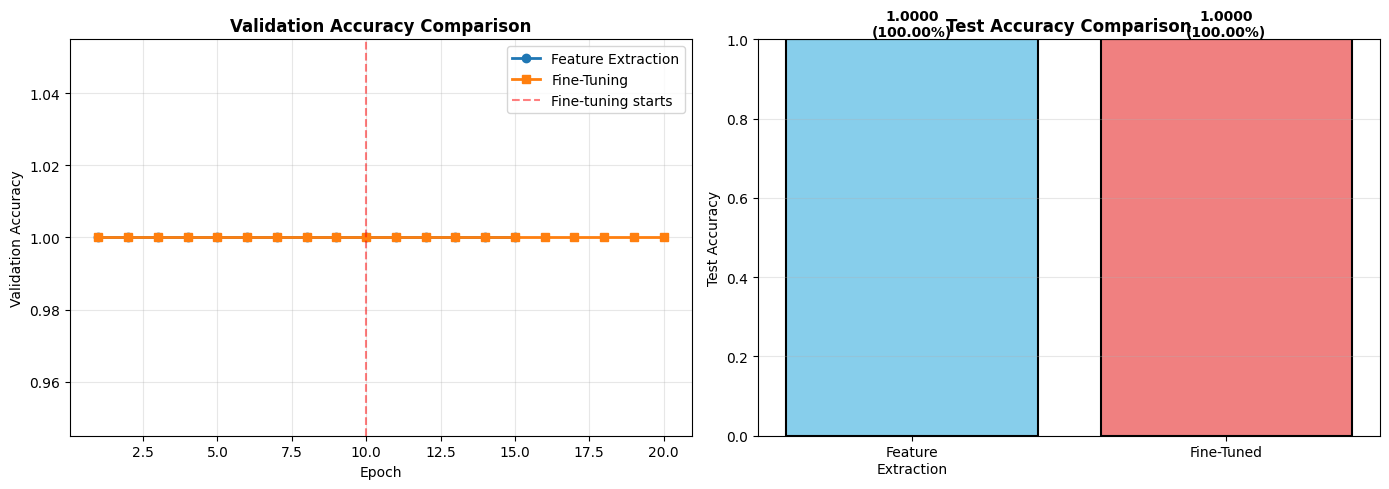


Key Insights:
1. Both approaches leverage pre-trained features effectively
2. Fine-tuning allows the model to adapt pre-trained features to our specific task
3. Fine-tuning typically achieves better performance but requires more training time
4. The choice depends on dataset size, similarity to source task, and computational resources


In [15]:
# Create a comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combine histories from both phases for fine-tuning
combined_accuracy = history_ft_phase1.history['accuracy'] + history_ft_phase2.history['accuracy']
combined_val_accuracy = history_ft_phase1.history['val_accuracy'] + history_ft_phase2.history['val_accuracy']

epochs_phase1 = range(1, len(history_ft_phase1.history['accuracy']) + 1)
epochs_phase2 = range(len(history_ft_phase1.history['accuracy']) + 1, 
                      len(history_ft_phase1.history['accuracy']) + len(history_ft_phase2.history['accuracy']) + 1)
all_epochs = range(1, len(combined_accuracy) + 1)

# Plot 1: Feature Extraction vs Fine-Tuning - Validation Accuracy
axes[0].plot(range(1, len(history_fe.history['val_accuracy']) + 1), 
             history_fe.history['val_accuracy'], 
             label='Feature Extraction', marker='o', linewidth=2)
axes[0].plot(all_epochs, combined_val_accuracy, 
             label='Fine-Tuning', marker='s', linewidth=2)
axes[0].axvline(x=len(history_ft_phase1.history['accuracy']), 
                color='red', linestyle='--', alpha=0.5, 
                label='Fine-tuning starts')
axes[0].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Model Performance Comparison
models_comparison = ['Feature\nExtraction', 'Fine-Tuned']
accuracies = [test_accuracy, test_accuracy_ft]
colors = ['skyblue', 'lightcoral']

bars = axes[1].bar(models_comparison, accuracies, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Test Accuracy')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.4f}\n({acc*100:.2f}%)',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("1. Both approaches leverage pre-trained features effectively")
print("2. Fine-tuning allows the model to adapt pre-trained features to our specific task")
print("3. Fine-tuning typically achieves better performance but requires more training time")
print("4. The choice depends on dataset size, similarity to source task, and computational resources")

## Hands-On Activity: Experiment with Different Pre-trained Models

Now it's your turn! Try experimenting with different pre-trained models and compare their performance.

In [16]:
# Exercise: Try using MobileNetV2 instead of VGG16
# MobileNetV2 is a lightweight model designed for mobile devices

print("Exercise: Implement transfer learning with MobileNetV2")
print("\nSteps:")
print("1. Load MobileNetV2 pre-trained model (already imported)")
print("2. Freeze the base layers")
print("3. Add custom classifier layers")
print("4. Train and evaluate the model")
print("5. Compare with VGG16 results")

# Starter code:
base_model_mobile = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(64, 64, 3)
)

base_model_mobile.trainable = False

model_mobile = models.Sequential([
    base_model_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

print(f"\nMobileNetV2 model created!")
print(f"Total parameters: {model_mobile.count_params():,}")
print(f"\nCompare this with VGG16:")
print(f"VGG16 total parameters: {model_feature_extraction.count_params():,}")
print(f"\nMobileNetV2 is {model_feature_extraction.count_params() / model_mobile.count_params():.1f}x smaller!")

# Now compile and train (uncomment to run)
# model_mobile.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_mobile = model_mobile.fit(
#     X_train, y_train,
#     epochs=15,
#     batch_size=32,
#     validation_split=0.2,
#     verbose=1
# )

print("\nTo complete the exercise, uncomment the training code above and run the cell!")

Exercise: Implement transfer learning with MobileNetV2

Steps:
1. Load MobileNetV2 pre-trained model (already imported)
2. Freeze the base layers
3. Add custom classifier layers
4. Train and evaluate the model
5. Compare with VGG16 results


      0/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

4153344/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

8880128/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



MobileNetV2 model created!
Total parameters: 2,422,339

Compare this with VGG16:
VGG16 total parameters: 14,879,299

MobileNetV2 is 6.1x smaller!

To complete the exercise, uncomment the training code above and run the cell!


## Key Takeaways

### Summary of Main Points

1. **Transfer Learning Fundamentals**
   - Transfer learning leverages knowledge from pre-trained models to solve new tasks
   - It's especially effective when you have limited data or computational resources
   - Pre-trained models capture general features applicable across many tasks

2. **Two Main Approaches**
   - **Feature Extraction:** Freeze pre-trained layers, train only new classifier layers
     - Faster training, fewer parameters to update
     - Best for small datasets and tasks similar to source domain
   - **Fine-Tuning:** Unfreeze some layers and continue training with small learning rate
     - Better performance, more flexibility
     - Best for moderate to large datasets

3. **Mathematical Insights**
   - Early layers learn general features (edges, textures)
   - Later layers learn task-specific features
   - Fine-tuning requires lower learning rates to preserve pre-trained knowledge: $\eta_{fine} \ll \eta_{scratch}$

4. **Practical Implementation**
   - Popular frameworks (TensorFlow, PyTorch) provide easy access to pre-trained models
   - Model selection depends on accuracy requirements, computational constraints, and dataset size
   - Always start with feature extraction, then try fine-tuning if needed

5. **What You Should Now Be Able To Do**
   - Load and use pre-trained models from TensorFlow/Keras
   - Implement both feature extraction and fine-tuning approaches
   - Freeze and unfreeze layers programmatically
   - Compare different pre-trained models for your task
   - Understand when to use transfer learning vs. training from scratch

### Best Practices

- **Start with feature extraction** before attempting fine-tuning
- **Use smaller learning rates** when fine-tuning (typically 10-100x smaller)
- **Monitor validation metrics** to avoid overfitting
- **Choose appropriate pre-trained models** based on your domain (VGG16/ResNet for general images, MobileNet for deployment)
- **Preprocess inputs** according to the pre-trained model's requirements
- **Experiment with different architectures** to find the best fit for your task

## Further Resources

### Official Documentation

1. **TensorFlow Transfer Learning Guide**  
   https://www.tensorflow.org/tutorials/images/transfer_learning  
   Comprehensive tutorial on transfer learning with TensorFlow and Keras

2. **Keras Applications Documentation**  
   https://keras.io/api/applications/  
   Complete list of pre-trained models available in Keras

3. **PyTorch Transfer Learning Tutorial**  
   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
   Transfer learning implementation using PyTorch

### Research Papers

4. **"A Survey on Transfer Learning" by Pan & Yang (2010)**  
   https://ieeexplore.ieee.org/document/5288526  
   Foundational paper on transfer learning theory and applications

5. **"How transferable are features in deep neural networks?" by Yosinski et al. (2014)**  
   https://arxiv.org/abs/1411.1792  
   Empirical investigation of feature transferability in neural networks

### Practical Guides

6. **CS231n: Transfer Learning Notes**  
   http://cs231n.github.io/transfer-learning/  
   Stanford's excellent notes on transfer learning in computer vision

7. **Pre-trained Models for Computer Vision**  
   https://modelzoo.co/  
   Repository of pre-trained models across different frameworks

### Advanced Topics

8. **Domain Adaptation and Transfer Learning**  
   Explore how to handle cases where source and target domains differ significantly

9. **Multi-Task Learning**  
   Learn about training models on multiple related tasks simultaneously

10. **Meta-Learning**  
    Study how models can "learn to learn" and quickly adapt to new tasks

### Next Steps

- Experiment with transfer learning on real-world datasets (Kaggle competitions, UCI ML Repository)
- Try transfer learning for other domains (NLP with BERT, audio with pre-trained CNNs)
- Explore advanced techniques like progressive unfreezing and discriminative learning rates
- Investigate domain adaptation methods for cases with significant domain shift